# Facial Emotion Recognition with using CNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install scikit-plot

In [3]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
warnings.simplefilter("ignore")

<h1 id="1"> <center>2. Loading the data</center> </h1> <a id="2"></a>

In [4]:
data= pd.read_csv("/content/drive/MyDrive/Deeplearning project/fer2013/fer2013.csv")

To see the dataset has any missing values.

In [5]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

There is no missing values

In [6]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


<h1 id="1"> <center>3. Data pre-processing</center> </h1> <a id="3"></a>

In [7]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
fig = px.bar(x = CLASS_LABELS,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] , 
             color = np.unique(data['emotion']) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

## 3.1 Shuffling the data




In [8]:
data = data.sample(frac=1)

Set the fraction to 1

## 3.2 One Hot Encoding

Then, we will do one hot encoding operation to change the categorical labels as numeric labels to learning algorithm can work better in predictions process.

In [9]:
labels = to_categorical(data[['emotion']], num_classes=7)

Changing image pixels to Numpy array


In [10]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

## 3.3 Standardization

In [11]:
pixels = train_pixels.reshape((35887*2304,1))

In [12]:
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

## 3.4 Reshaping the data (48,48,1)




After that, we will reshape the data to make our image pixels to split in 4dimentions and 1 will be for grayscale and 3 for RGB. 

In [13]:
pixels = train_pixels.reshape((35887, 48, 48,1))

## 3.5 Train test validation split


Now, we have 35887 images with each containing 48x48 pixels. We will split the data into train,test and Validation data to feed and evaluate and validate our data with the ratio of 10%.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


We can see some train data containing one sample of each class with the help of this plot code.

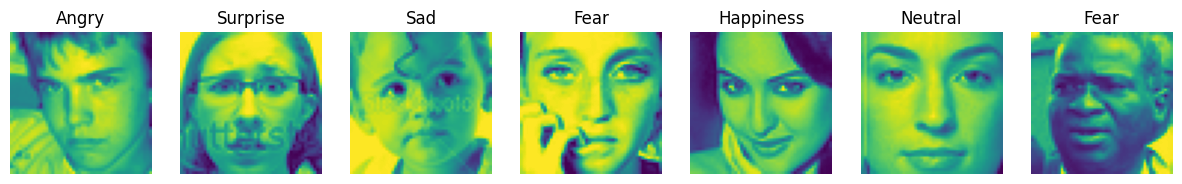

In [16]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

## 3.6 Data augmentation using ImageDataGenerator

We can do data augmentation to have more data to train and validate our model to prevent overfitting. Data augmentation can be done on training and validation sets as it helps the model become more generalize and robust.

In [17]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2) 

In [18]:
datagen.fit(X_train)
valgen.fit(X_val)

In [19]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

Our dataset is ready to feed our model. We will look at our model architecture.

<h1 id="1"> <center>4.  Design a model </center> </h1> <a id="4"></a>

## 4.1 CNN model

CNN model has many layers with different units such as Convolutional layer, Max pooling layer, Batch normalization and Drop out layer to regularize the model.

In [20]:
def cnn_model():

  model= tf.keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
  model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
  model.add(BatchNormalization())

  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
      
  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten()) 
  model.add(Dense(256,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))
      
  model.add(Dense(512,activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(7, activation='softmax'))
  model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
  return model

In [21]:
model = cnn_model()

Then, we compile our model with Adam optimizer with 0.0001 learning rate and chose metric as accuracy, then loss as categorical crossentropy

In [22]:
model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

## 4.2 Early stopping

Adding checkpointer to implement Early Stopping to prevent overfitting.

In [24]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 5),
                ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

In [25]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
455/455 [==============================] - ETA: 0s - loss: 14.0627 - accuracy: 0.1821
Epoch 1: val_accuracy improved from -inf to 0.24985, saving model to best_model.h5
455/455 [==============================] - 50s 59ms/step - loss: 14.0627 - accuracy: 0.1821 - val_loss: 12.8863 - val_accuracy: 0.2498
Epoch 2/30
455/455 [==============================] - ETA: 0s - loss: 12.1705 - accuracy: 0.2102
Epoch 2: val_accuracy improved from 0.24985 to 0.25511, saving model to best_model.h5
455/455 [==============================] - 29s 64ms/step - loss: 12.1705 - accuracy: 0.2102 - val_loss: 10.9494 - val_accuracy: 0.2551
Epoch 3/30
454/455 [============================>.] - ETA: 0s - loss: 10.2121 - accuracy: 0.2281
Epoch 3: val_accuracy improved from 0.25511 to 0.27461, saving model to best_model.h5
455/455 [==============================] - 23s 50ms/step - loss: 10.2094 - accuracy: 0.2282 - val_loss: 9.1069 - val_accuracy: 0.2746
Epoch 4/30
454/455 [============================>.

## 4.3 Visualizing results

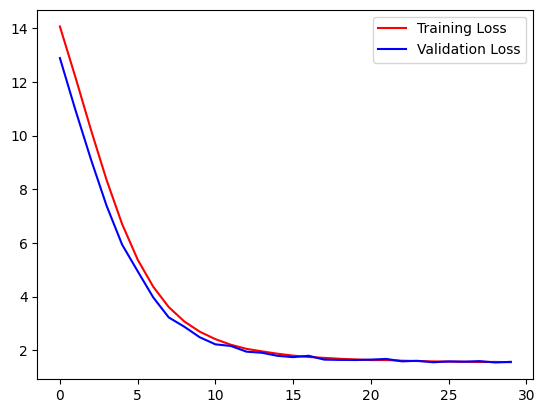

In [26]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

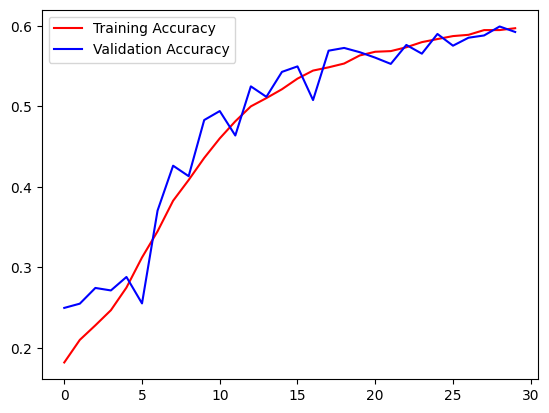

In [27]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [28]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 2s 9ms/step - loss: 1.5269 - accuracy: 0.6052
Test Acc: 0.6051825284957886


In [29]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 1s 6ms/step


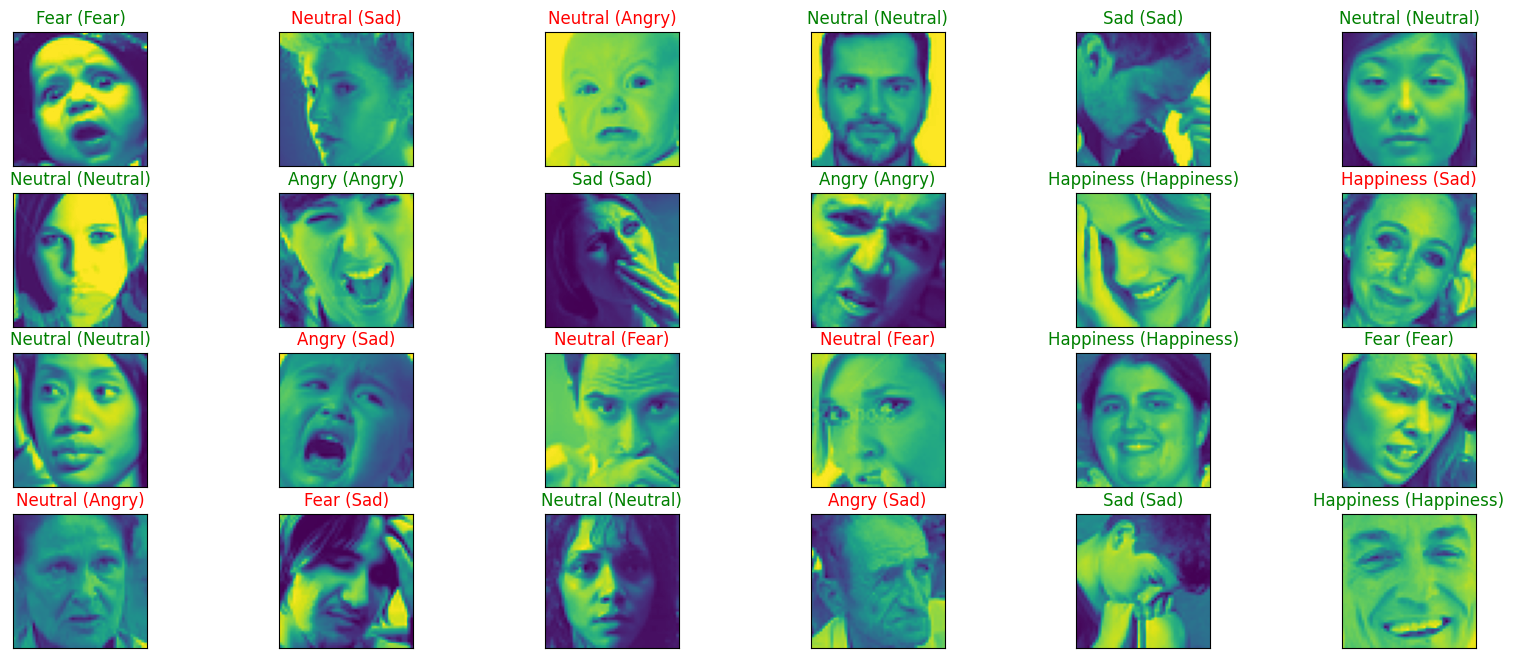

In [30]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

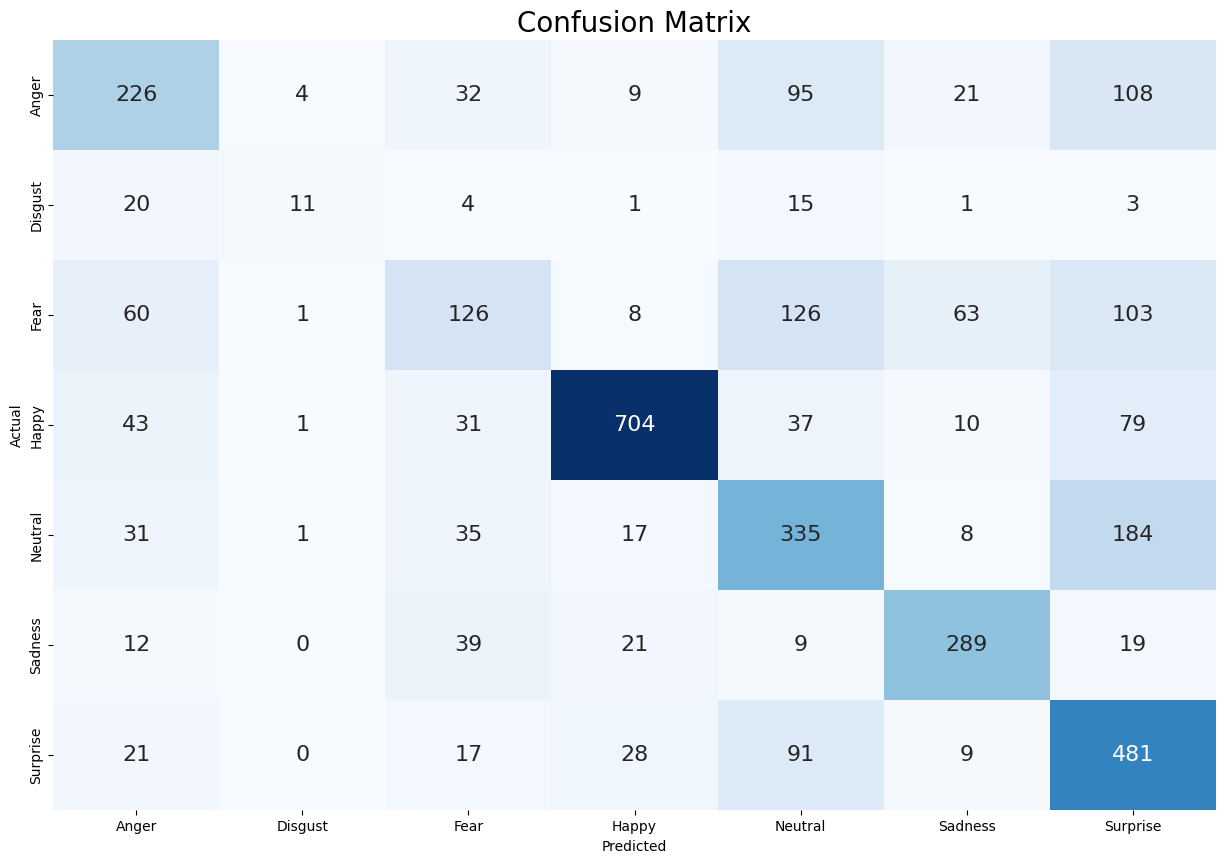

In [31]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [32]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.547     0.457     0.498       495
           1      0.611     0.200     0.301        55
           2      0.444     0.259     0.327       487
           3      0.893     0.778     0.832       905
           4      0.473     0.548     0.508       611
           5      0.721     0.743     0.732       389
           6      0.492     0.743     0.592       647

    accuracy                          0.605      3589
   macro avg      0.597     0.533     0.541      3589
weighted avg      0.618     0.605     0.600      3589



<h1 id="1"> <center>5. Fine tuning</center> </h1> <a id="5"></a>

## 5.1 Changing optimizer

Changing Optimizer to SGD (Stochastic Gradient Descent )

In [33]:
model = cnn_model()

In [34]:
model.compile(optimizer=tf.keras.optimizers.SGD(0.001),
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

In [35]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
455/455 [==============================] - ETA: 0s - loss: 14.8354 - accuracy: 0.1647
Epoch 1: val_accuracy did not improve from 0.59907
455/455 [==============================] - 26s 50ms/step - loss: 14.8354 - accuracy: 0.1647 - val_loss: 14.0661 - val_accuracy: 0.2084
Epoch 2/30
455/455 [==============================] - ETA: 0s - loss: 14.3965 - accuracy: 0.1749
Epoch 2: val_accuracy did not improve from 0.59907
455/455 [==============================] - 23s 50ms/step - loss: 14.3965 - accuracy: 0.1749 - val_loss: 13.7801 - val_accuracy: 0.2508
Epoch 3/30
454/455 [============================>.] - ETA: 0s - loss: 14.0635 - accuracy: 0.1863
Epoch 3: val_accuracy did not improve from 0.59907
455/455 [==============================] - 21s 47ms/step - loss: 14.0634 - accuracy: 0.1863 - val_loss: 13.5537 - val_accuracy: 0.2334
Epoch 4/30
454/455 [============================>.] - ETA: 0s - loss: 13.7668 - accuracy: 0.1952
Epoch 4: val_accuracy did not improve from 0.59907
455

In [36]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 7ms/step - loss: 8.7754 - accuracy: 0.3642
Test Acc: 0.36416828632354736


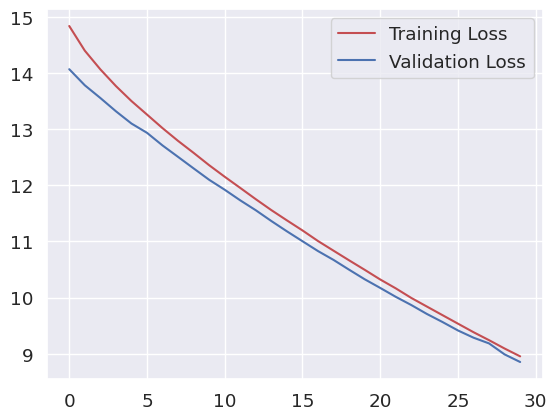

In [37]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

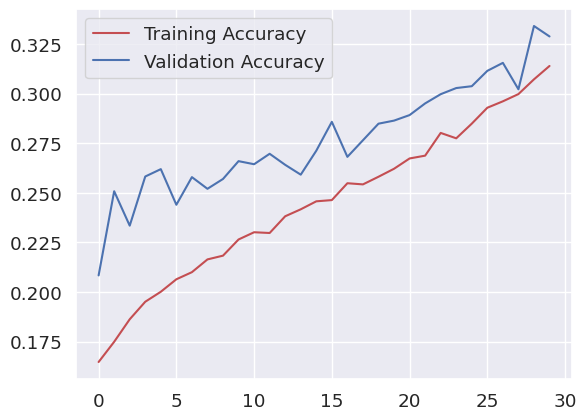

In [38]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

The model trained with SGD did not give better results than Adam optimizer.

## 5.2 Changing epoch number

Let's change the epoch number as 50 for the cnn_model.

In [39]:
model = cnn_model()

In [40]:
model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [41]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

In [42]:
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/50
454/455 [============================>.] - ETA: 0s - loss: 14.0807 - accuracy: 0.1832
Epoch 1: val_accuracy improved from -inf to 0.20372, saving model to best_model.h5
455/455 [==============================] - 29s 49ms/step - loss: 14.0787 - accuracy: 0.1832 - val_loss: 12.9406 - val_accuracy: 0.2037
Epoch 2/50
454/455 [============================>.] - ETA: 0s - loss: 12.2011 - accuracy: 0.2117
Epoch 2: val_accuracy improved from 0.20372 to 0.24768, saving model to best_model.h5
455/455 [==============================] - 23s 51ms/step - loss: 12.1991 - accuracy: 0.2118 - val_loss: 11.0659 - val_accuracy: 0.2477
Epoch 3/50
455/455 [==============================] - ETA: 0s - loss: 10.2528 - accuracy: 0.2242
Epoch 3: val_accuracy improved from 0.24768 to 0.26130, saving model to best_model.h5
455/455 [==============================] - 23s 51ms/step - loss: 10.2528 - accuracy: 0.2242 - val_loss: 9.1618 - val_accuracy: 0.2613
Epoch 4/50
455/455 [==============================

In [43]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 1s 8ms/step - loss: 1.4301 - accuracy: 0.6450
Test Acc: 0.645026445388794


In [44]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 1s 6ms/step


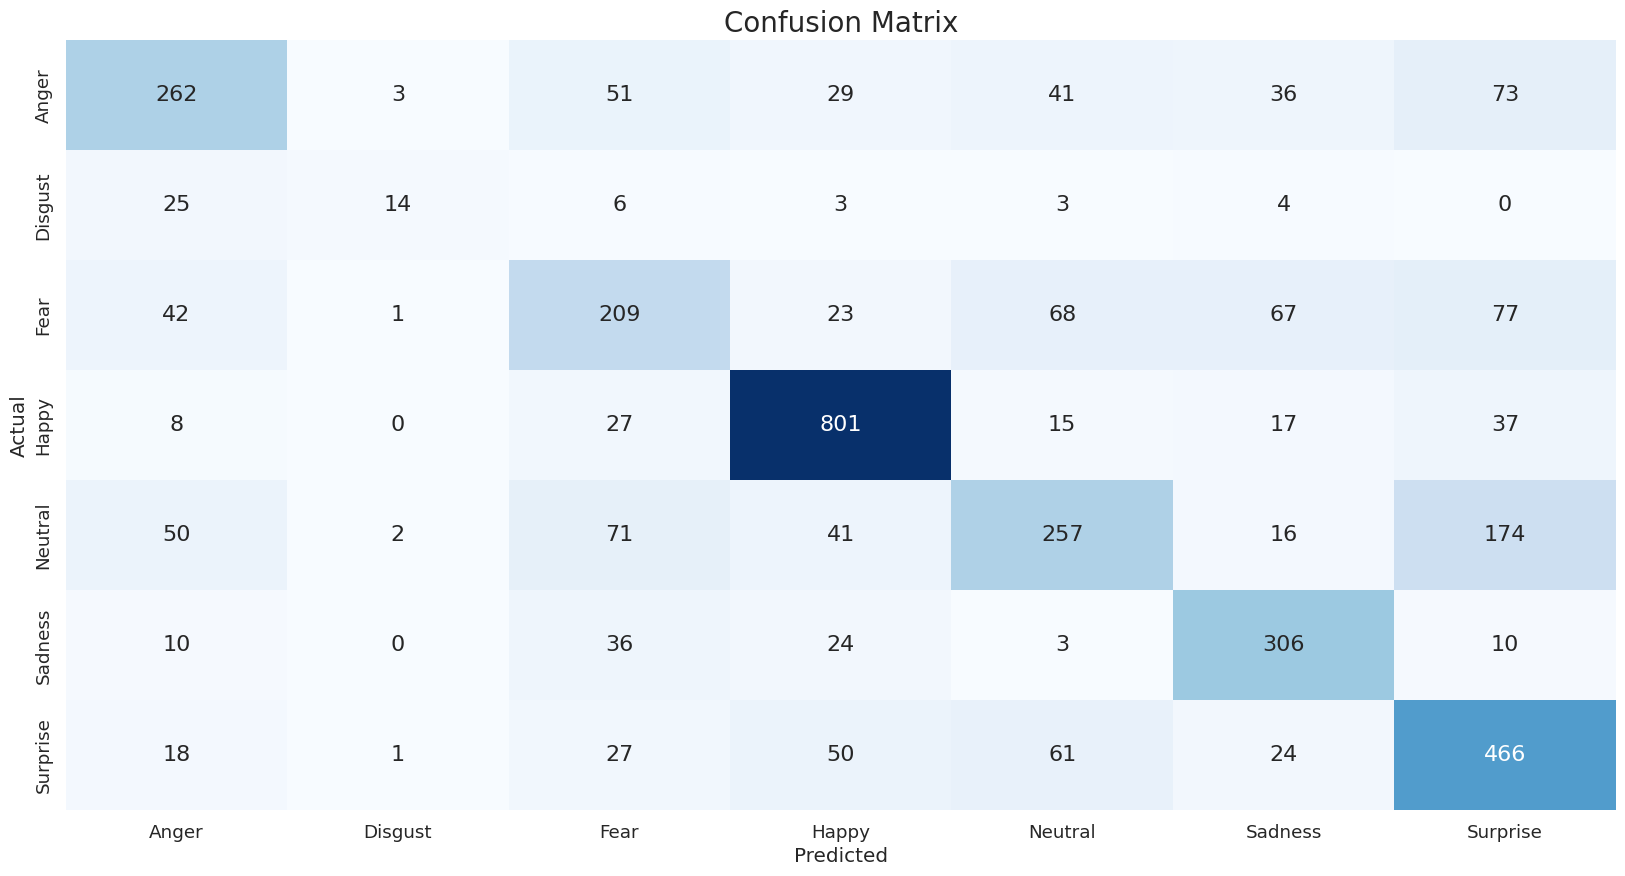

In [45]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [46]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.631     0.529     0.576       495
           1      0.667     0.255     0.368        55
           2      0.489     0.429     0.457       487
           3      0.825     0.885     0.854       905
           4      0.574     0.421     0.485       611
           5      0.651     0.787     0.712       389
           6      0.557     0.720     0.628       647

    accuracy                          0.645      3589
   macro avg      0.628     0.575     0.583      3589
weighted avg      0.640     0.645     0.636      3589



The final outcome is that the model trained with 50 epochs has better results than compared to  the model trained with 30 epochs.